# Backtesting with itermittent refit
### Single and Multiple time-series: Direct & Recursive forecasting
### Expanding Training Window & Rolling Training Window
Note: The argument needed: `refit=n`, where n is an integer. This configuration also allows the use of `fixed_train_size` to implement a rolling training window.   
Conda environment: `time-series`  
05 Jul 2024

In [13]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

from skforecast.datasets import fetch_dataset
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import backtesting_forecaster

/Users/razielar/miniconda3/envs/time-series/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configs

# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plotsize = (22, 5)
plt.rcParams['figure.figsize'] = plotsize

# Pandas config
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_columns = 200

## 1) Single time series

In [4]:
# Load the data
data = fetch_dataset(name="h2o_exog", raw=True)
data

h2o_exog
--------
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008. Two additional variables (exog_1, exog_2) are
simulated.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice (3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,
https://github.com/robjhyndman/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (195, 4)


,fecha,y,exog_1,exog_2
0,1992-04-01,0.3798,0.9588,1.1660
1,1992-05-01,0.3618,0.9520,1.1179
2,1992-06-01,0.4105,0.9530,1.0679
3,1992-07-01,0.4834,0.9581,1.0974
4,1992-08-01,0.4755,0.9564,1.1222
...,...,...,...,...
190,2008-02-01,0.7618,1.5158,1.7864
191,2008-03-01,0.6494,1.5063,1.6943
192,2008-04-01,0.8279,1.5053,1.6271
193,2008-05-01,0.8163,1.4915,1.5551


In [5]:
# Data preparation
data = data.rename(columns={"fecha": "date"})
data["date"] = pd.to_datetime(data["date"], format="%Y-%m-%d")
data = data.set_index("date")
data = data.asfreq("MS")
data = data.sort_index()
data.head()

,y,exog_1,exog_2
date,,,
1992-04-01,0.3798,0.9588,1.1660
1992-05-01,0.3618,0.9520,1.1179
1992-06-01,0.4105,0.9530,1.0679
1992-07-01,0.4834,0.9581,1.0974
1992-08-01,0.4755,0.9564,1.1222


In [6]:
# Check for missing values
print(f"Number of rows with missing values: {data.isnull().any(axis=1).sum()}")

Number of rows with missing values: 0


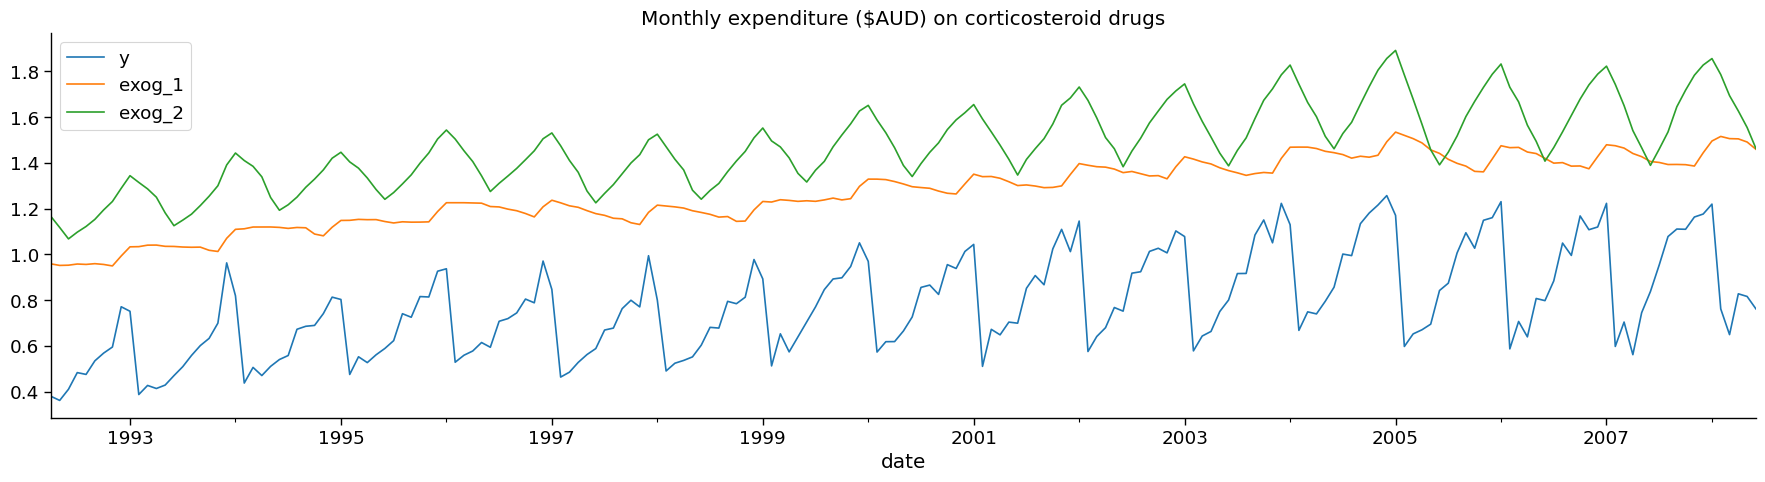

In [8]:
# Plot data
ax = data.plot()
ax.set_title("Monthly expenditure ($AUD) on corticosteroid drugs")
plt.show()

### 1.2) Direct Forecasting
In this case, we refit every 2 step. So using a window of 3 then we refit 1.

In [14]:
# Create forecaster
HORIZON = 7  # Number of steps to forecast

forecaster = ForecasterAutoregDirect(
    regressor=Ridge(alpha=1),
    lags=6,
    steps=HORIZON,
    transformer_y=StandardScaler(),  # Scaling helpful for
    transformer_exog=StandardScaler(),  # linear models.
)

# Number of datapoints to test over
n_backtesting = HORIZON * 3

# Initial training set size
initial_train_size = len(data) - n_backtesting

# Refit the model every `refit` (2) steps
refit = 2

metric, predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=data["y"],
    exog=data[["exog_1", "exog_2"]],
    initial_train_size=initial_train_size,
    allow_incomplete_fold=True,
    fixed_train_size=False, # Expanding Training Window
    steps=HORIZON,
    metric="mean_squared_error",
    refit=refit,
    verbose=True,
    show_progress=True,
)

print(f"Backtest metric (MSE): {metric}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 174
Number of observations used for backtesting: 21
    Number of folds: 3
    Number of steps per fold: 7
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2006-10-01 00:00:00 -- 2007-04-01 00:00:00  (n=7)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2006-09-01 00:00:00  (n=174)
    Validation: 2007-05-01 00:00:00 -- 2007-11-01 00:00:00  (n=7)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2007-11-01 00:00:00  (n=188)
    Validation: 2007-12-01 00:00:00 -- 2008-06-01 00:00:00  (n=7)



100%|██████████| 3/3 [00:00<00:00, 36.98it/s]

Backtest metric (MSE): 0.012116099182152843
